# Connecting to your data

In [1]:
import datajoint as dj
dj.config['enable_python_native_blobs'] = True
dj.__version__

'0.12.5'

In [2]:
dj.config

{   'connection.charset': '',
    'connection.init_function': None,
    'database.host': 'db',
    'database.password': 'coogs',
    'database.port': 3306,
    'database.reconnect': True,
    'database.use_tls': None,
    'database.user': 'root',
    'display.limit': 12,
    'display.show_tuple_count': True,
    'display.width': 14,
    'enable_python_native_blobs': True,
    'fetch_format': 'array',
    'loglevel': 'INFO',
    'safemode': True}

## Open connection to a database server instance i.e. Pipeline

In [3]:
# dj.conn(host='db', user='root', password='coogs')
dj.conn()

Connecting root@db:3306


DataJoint connection (connected) root@db:3306

In [4]:
dj.list_schemas()

['mysql', 'performance_schema', 'sys']

# Structuring your data using a database i.e. Schema

In [5]:
schema = dj.Schema('uh_showcase')

In [6]:
dj.Di(schema)

In [7]:
@schema
class Sport(dj.Manual):
    definition = """
    sport_id        :  int auto_increment
    ---
    name      : varchar(30)
    sex="men" : enum("women", "men")
    unique index(name, sex)
    """

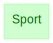

In [8]:
dj.Di(schema)

In [9]:
Sport.insert([
    dict(name='swim', sex='women'),
    dict(name='soc', sex='women')
])
Sport.insert([
    dict(name='track'),
    dict(name='football')
])

In [10]:
Sport()

sport_id,name,sex
4,football,men
2,soc,women
1,swim,women
3,track,men


In [11]:
import datetime

In [12]:
@schema
class NewsArticle(dj.Manual):
    definition = """
    -> Sport
    news_id       : int
    ---
    date=null: date
    """

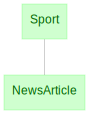

In [13]:
dj.Di(schema)

In [14]:
NewsArticle.insert([
    [4, 1, datetime.date(2020,3,3)],
    [2, 1, datetime.date(2019,11,5)],
    [1, 1, datetime.date(2020,3,11)],
    [3, 1, datetime.date(2020,3,4)],
])
# NewsArticle.insert([
#     dict(sport_id=1, news_id=1),
#     dict(sport_id=3, news_id=1)
# ])

In [15]:
NewsArticle()

sport_id,news_id,date
1,1,2020-03-11
2,1,2019-11-05
3,1,2020-03-04
4,1,2020-03-03


In [16]:
import requests
import json
import re
from os import path, mkdir

In [17]:
@schema
class Headline(dj.Imported):
    definition = """
    -> NewsArticle
    ---
    name : varchar(200)
    image: longblob
    """
    def make(self, key):    
        sport_name, sport_sex = (Sport & key).fetch1('name', 'sex')
        news_date = (NewsArticle & key).fetch1('date')
        file_path = 'cached/{}_{}_{}.JPG'.format(sport_name, sport_sex, news_date)
        
        if not path.exists(file_path):
            base_url = "https://uhcougars.com"
            headers = {
                'User-Agent': "DataJoint"
            }
            querystring = {
                "index":"1",
                "page_size":"30",
                "sport": sport_name if sport_sex != 'women' else sport_sex[0] + sport_name,
                "season":"0"
            }
            response = requests.request("GET", base_url + "/services/archives.ashx/stories", headers=headers, params=querystring)
            article = [v for v in json.loads(response.text)['data'] if v['story_postdate'] == news_date.strftime("%-m/%-d/%Y")][0] if news_date else json.loads(response.text)['data'][0]
            news_date = datetime.datetime.strptime(article['story_postdate'], '%m/%d/%Y').date() if not news_date else news_date
            response = requests.request("GET", base_url + article['story_path'], headers=headers)
            image_path = re.findall(r'<img src="/images/{year}[A-Za-z0-9/_.\-]+'.format(year=news_date.year), response.text)[0][10:]
            response = requests.request("GET", base_url + image_path, headers=headers)
            if not path.exists(path.dirname(file_path)):
                mkdir(path.dirname(file_path))
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print('Image `{}` downloaded.'.format(file_path))
            key['name'] = article['story_headline']
        else:
            key['name'] = 'No Title (loaded from cache)'
            print('Image `{}` read from cache.'.format(file_path))
            
        with open(file_path, mode='rb') as f:
            key['image'] = f.read()
        self.insert1(key)

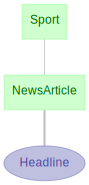

In [18]:
dj.Di(schema)

In [19]:
Headline.populate()

Image `cached/swim_women_2020-03-11.JPG` read from cache.
Image `cached/soc_women_2019-11-05.JPG` read from cache.
Image `cached/track_men_2020-03-04.JPG` read from cache.
Image `cached/football_men_2020-03-03.JPG` read from cache.


In [20]:
q_original = Headline()
q_original = Headline & dict(sport_id=1, news_id=1)
q_original

sport_id,news_id,name,image
1,1,No Title (loaded from cache),=BLOB=


In [21]:
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

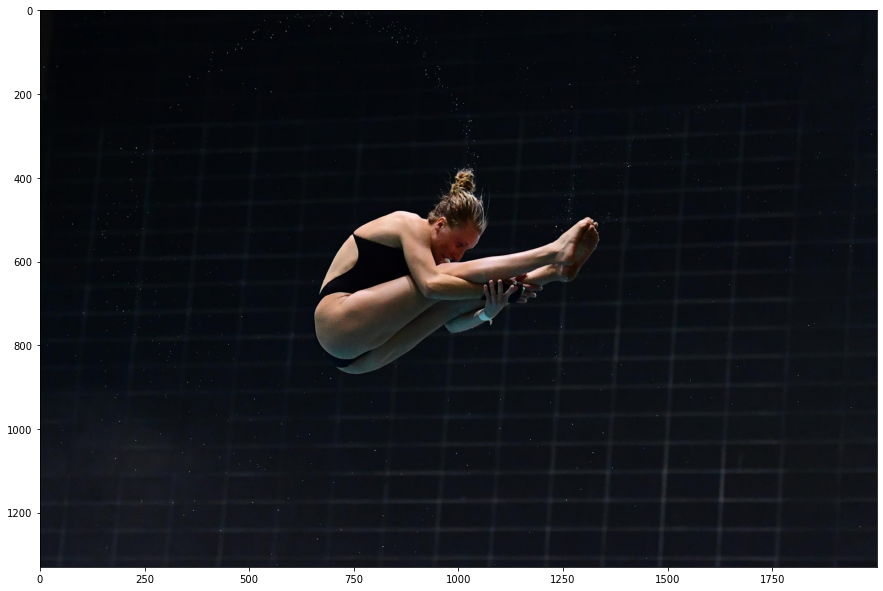

In [22]:
image_original = q_original.fetch1('image')
image_original = Image.open(BytesIO(image_original))
fig, axarr = plt.subplots(1,1,figsize=(15,15))
axarr.imshow(image_original)

In [23]:
@schema
class PaintingStyle(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = [
        ['udnie']
    ]

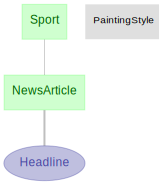

In [24]:
dj.Di(schema)

In [25]:
PaintingStyle.insert([
    dict(style_name='la_muse')
])

In [26]:
PaintingStyle()

style_name
la_muse
udnie


In [27]:
import numpy as np
import cv2
import imutils

In [28]:
@schema
class Flyer(dj.Computed):
    definition = """
    -> Headline
    -> PaintingStyle
    ---
    image: longblob
    """
    def make(self, key):
        style_path = 'models/' + key['style_name'] + '.t7'
        image = (Headline & key).fetch1('image')
        
        net = cv2.dnn.readNetFromTorch(style_path)
        image = np.frombuffer(image, np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        image = imutils.resize(image, width=600)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
            (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        
        print('sport_id: {sport_id}, news_id: {news_id}, style_name: {style_name}'.format(**key))
        
        key['image'] = cv2.imencode('.jpg', output)[1].tostring()
        self.insert1(key)

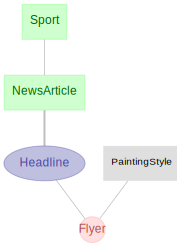

In [29]:
dj.Di(schema)

In [30]:
Flyer.populate()

sport_id: 1, news_id: 1, style_name: la_muse
sport_id: 1, news_id: 1, style_name: udnie
sport_id: 2, news_id: 1, style_name: la_muse
sport_id: 2, news_id: 1, style_name: udnie
sport_id: 3, news_id: 1, style_name: la_muse
sport_id: 3, news_id: 1, style_name: udnie
sport_id: 4, news_id: 1, style_name: la_muse
sport_id: 4, news_id: 1, style_name: udnie


In [31]:
q_styled = Flyer()
q_styled = Flyer & dict(sport_id=1, news_id=1, style_name='la_muse')
# q_styled = Flyer & dict(sport_id=1, news_id=1, style_name='udnie')
q_styled

sport_id,news_id,style_name,image
1,1,la_muse,=BLOB=


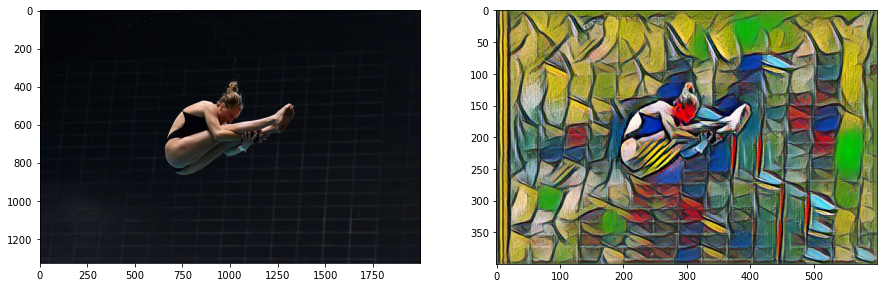

In [32]:
image_styled = q_styled.fetch1('image')
image_styled = Image.open(BytesIO(image_styled))

fig, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(image_original)
axarr[1].imshow(image_styled)

# Clean up and remove generated data

In [33]:
schema.drop()

Proceed to delete entire schema `uh_showcase`? [yes, No]:  yes


In [34]:
import shutil
shutil.rmtree('cached')

# Trash

In [ ]:
fetched_result = (Headline & dict(sport_id=4, news_id=1)).fetch1('image')
# image = np.frombuffer(fetched_result, np.uint8)
# image_bytes = image
# image_bytes = image_bytes.tobytes()

image = np.frombuffer(fetched_result, np.uint8)
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.imencode('.jpg', image)[1].tostring()
with open('test.jpg', 'wb') as f:
    f.write(image)
print(len(fetched_result))
print(len(image))


# image = np.frombuffer(fetched_result, np.uint8)
# ret,buf=cv.imencode(".jpg",image)
# bufjpg = bytearray(buf)
# fs = open("toto.jpg", "wb")
# fs.write(bufjpg)
# print (buf[0:15].tostring())
# img=cv.imdecode(buf,cv.IMREAD_COLOR)

# image = cv2.imdecode(image, cv2.IMREAD_COLOR)
# image_bytes = cv2.imencode('.JPG', image)[1].tostring()
# image = cv2.imdecode(image, cv2.IMREAD_COLOR)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# img_bytes = cv2.imencode('.jpg', image)[1].tobytes('C')
# assert image_bytes == fetched_result, 'No way...'

In [ ]:
fetched_result = (Headline & dict(sport_id=4, news_id=1)).fetch1('image')
im = Image.open(BytesIO(fetched_result))
im_mat = imageio.imread(fetched_result)
# with BytesIO() as output_bytes:
#     im.save(output_bytes, 'JPEG') # Note JPG is not a vaild type here
#     bytes_data = output_bytes.getvalue()
# assert bytes_data == fetched_result, 'Don\'t match!'
im
# plt.imshow(im_mat)

In [ ]:
style_path = 'models/' + 'udnie' + '.t7'
image = (Headline & dict(sport_id=1, news_id=1)).fetch1('image')
# image
net = cv2.dnn.readNetFromTorch(style_path)
image = np.frombuffer(image, np.uint8)
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image, set the input, and then perform a
# forward pass of the network
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
    (103.939, 116.779, 123.680), swapRB=False, crop=False)
net.setInput(blob)
output = net.forward()


# reshape the output tensor, add back in the mean subtraction, and
# then swap the channel ordering
output = output.reshape((3, output.shape[2], output.shape[3]))

output[0] += 103.939

output[1] += 116.779

output[2] += 123.680

output = output.transpose(1, 2, 0)
output = np.clip(output, 0, 255)
output= output.astype('uint8')


test = cv2.imencode('.jpg', output)[1].tostring()
with open('test.jpg', 'wb') as f:
    f.write(test)



fig, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

In [ ]:
Flyer.populate()

In [ ]:
fetched_result = (Flyer & dict(sport_id=4, news_id=1, style_name='udnie')).fetch1('image')
im = Image.open(BytesIO(fetched_result))
im_mat = imageio.imread(fetched_result)
# with BytesIO() as output_bytes:
#     im.save(output_bytes, 'JPEG') # Note JPG is not a vaild type here
#     bytes_data = output_bytes.getvalue()
# assert bytes_data == fetched_result, 'Don\'t match!'
im
# plt.imshow(im_mat)

In [ ]:
fetched_result = (Flyer & dict(sport_id=4, news_id=1, style_name='udnie')).fetch1('image')
# image = np.frombuffer(fetched_result, np.uint8)
# image_bytes = image
# image_bytes = image_bytes.tobytes()

image = np.frombuffer(fetched_result, np.uint8)
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
plt.imshow(image)
# image = cv2.imencode('.jpg', image)[1].tostring()
# with open('test.jpg', 'wb') as f:
#     f.write(image)
# print(len(fetched_result))
# print(len(image))

In [ ]:
fetched_result = (Flyer & dict(sport_id=4, news_id=1, style_name='udnie')).fetch1('image')
Image.open(BytesIO(fetched_result))
# plt.imshow((Flyer & dict(sport_id=4, news_id=1, style_name='udnie')).fetch1('image'))

In [ ]:
plt.imshow(image)

In [ ]:
Sport & 'sport_sex="men"'

In [ ]:
Sport - 'sport_sex="men"'